In [199]:
import keras
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
import tensorflow as tf  # maybe
import nibabel as nib
from scipy import ndimage
import os
import shutil
from tensorflow.keras import layers, models, regularizers
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Concatenate, Conv2D, GlobalMaxPooling2D, Dense, BatchNormalization, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

In [176]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if "GPU" not in device_name:
    print("GPU device not found")
    
print('Found GPU at: {}'.format(device_name))

print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

Found GPU at: /device:GPU:0
GPU available (YESS!!!!)


In [200]:
dataset = "/kaggle/input/split-data-vol2/Split_Data_vol2"

In [178]:
os.path.exists(dataset)
os.path.os.listdir(dataset)

['val', 'test', 'train']

In [201]:
train_dir = os.path.join(dataset,"train")
test_dir = os.path.join(dataset,"test")
val_dir = os.path.join(dataset,"val")

In [180]:
os.path.os.listdir(test_dir)

['MCI', 'AD', 'CN']

In [202]:
# Manually define label mapping  
label_mapping = {  
    'AD': 0,  # Alzheimer's Disease  
    'CN': 1,  # Cognitively Normal  
    'MCI': 2   # Mild Cognitive Impairment  
}  

# Normalization layer  
normalization_layer = layers.Rescaling(1./255)  

# Preprocess function  
def preprocess_data(images, labels):  
    images = normalization_layer(images)  # Normalize images to [0, 1]  
    return images, labels  

# Load datasets with processing  
def load_dataset(directory):  
    return tf.keras.utils.image_dataset_from_directory(  
        directory,  
        image_size=(224, 224),  
        color_mode="grayscale",  
        batch_size=16,  
        label_mode='categorical'  # this will map labels based on folder names  
    ).map(lambda x, y: preprocess_data(x, y))  

# Load datasets  
train_ds = load_dataset(train_dir)
val_ds = load_dataset(val_dir)
test_ds = load_dataset(test_dir)

# To extract manual labels, create a custom labelling function  
def manual_label_extractor(labels):  
    return tf.one_hot(tf.argmax(labels, axis=-1), depth=len(label_mapping))  

# Set the labels manually  
train_ds = train_ds.map(lambda x, y: (x, y))
val_ds = val_ds.map(lambda x, y: (x, y))
test_ds = test_ds.map(lambda x, y: (x, y))

Found 1794 files belonging to 3 classes.
Found 451 files belonging to 3 classes.
Found 563 files belonging to 3 classes.


In [204]:
# Load the pre-trained VGG16 model
base_model = VGG16(
    include_top=False,  # Exclude the classification layer
    weights=weights_path,  # Downloaded pre-trained weights of ImageNet
    input_shape=(224, 224, 3),  # Input shape for VGG16
    pooling=None  
)
model.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_118           │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_55            │ (None, 224, 224, 3)    │              0 │ input_layer_118[0][0], │
│ (Concatenate)             │                        │                │ input_layer_118[0][0], │
│                           │                        │                │ input_layer_118[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ concatenate_55[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_68   │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_110 (Dense)         │ (None, 128)            │         65,664 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_71    │ (None, 128)            │            512 │ dense_110[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_63             │ (None, 128)            │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_66 (Dropout)      │ (None, 128)            │              0 │ activation_63[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_111 (Dense)         │ (None, 64)             │          8,256 │ dropout_66[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_72    │ (None, 64)             │            256 │ dense_111[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_64             │ (None, 64)             │              0 │ batch_normalization_7… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_67 (Dropout)      │ (None, 64)             │              0 │ activation_64[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_112 (Dense)         │ (None, 24)             │          1,560 │ dropout_67[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_73    │ (None, 24)             │             96 │ dense_112[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_65             │ (None, 24)             │              0 │ batch_normalization_7… │
│ (Activation)         

 Total params: 14,791,107 (56.42 MB)

 Trainable params: 13,055,187 (49.80 MB)

 Non-trainable params: 1,735,920 (6.62 MB)

In [205]:
# Function to count class distribution
def count_classes(dataset):
    class_counts = [0] * len(label_mapping)  # Initialize a list to hold class counts

    # Iterate over the dataset and count instances of each class
    for _, labels in dataset:
        class_indices = tf.argmax(labels, axis=-1)  # Get the index of the class for each sample
        for idx in class_indices.numpy():
            class_counts[idx] += 1
    
    return class_counts  # Return the correct variable

# Example usage to count classes in the training set
print("Train class distribution:", count_classes(train_ds))
print("Val class distribution:", count_classes(val_ds))
print("Test class distribution:", count_classes(test_ds))

Train class distribution: [489, 765, 540]
Val class distribution: [123, 192, 136]
Test class distribution: [153, 240, 170]


In [183]:
# Inspect some samples from the dataset
for images, labels in val_ds.take(2):  # Take one batch
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Labels (one-hot encoded): {labels.numpy()}")


Image batch shape: (16, 224, 224, 1)
Label batch shape: (16, 3)
Labels (one-hot encoded): [[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Image batch shape: (16, 224, 224, 1)
Label batch shape: (16, 3)
Labels (one-hot encoded): [[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [206]:
def freeze_layers(model, layer_indices):
    for i in layer_indices:
        model.layers[i].trainable = False
# freeze_layers(base_model, layer_indices=list(range(0, 15)))
# print("The following layers will be frozen:")
# for i, layer in enumerate(base_model.layers[:15]):
#     print(f"Layer {i} - {layer.name} - Trainable: {layer.trainable}")


In [207]:
weights_path = "/kaggle/input/vgg16/tensorflow2/default/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
os.path.exists(weights_path)

True

In [275]:
# Load the pre-trained VGG16 model
base_model = VGG16(
    include_top=False,  # Exclude the classification layer
    weights=weights_path,  # Downloaded pre-trained weights of ImageNet
    input_shape=(224, 224, 3),  # Input shape for VGG16
    pooling=None  
)

# Define the input layer for grayscale images
inputs = Input(shape=(224, 224, 1))  # Grayscale input (1 channel)

# Convert grayscale to RGB by replicating the single channel
rgb_inputs = Concatenate()([inputs, inputs, inputs])

# Preprocess the inputs for VGG16
processed_inputs = preprocess_input(rgb_inputs)
freeze_layers(base_model, layer_indices=list(range(0, 15)))
print("The following layers will be frozen:")
for i, layer in enumerate(base_model.layers[:15]):
    print(f"Layer {i} - {layer.name} - Trainable: {layer.trainable}")


x = base_model(rgb_inputs)
x = GlobalMaxPooling2D()(x)


x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)

x = Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)


# Output layer
outputs = Dense(3, activation="softmax")(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=Adam(1e-5),  
    loss=CategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


The following layers will be frozen:
Layer 0 - input_layer_163 - Trainable: False
Layer 1 - block1_conv1 - Trainable: False
Layer 2 - block1_conv2 - Trainable: False
Layer 3 - block1_pool - Trainable: False
Layer 4 - block2_conv1 - Trainable: False
Layer 5 - block2_conv2 - Trainable: False
Layer 6 - block2_pool - Trainable: False
Layer 7 - block3_conv1 - Trainable: False
Layer 8 - block3_conv2 - Trainable: False
Layer 9 - block3_conv3 - Trainable: False
Layer 10 - block3_pool - Trainable: False
Layer 11 - block4_conv1 - Trainable: False
Layer 12 - block4_conv2 - Trainable: False
Layer 13 - block4_conv3 - Trainable: False
Layer 14 - block4_pool - Trainable: False


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_164           │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_77            │ (None, 224, 224, 3)    │              0 │ input_layer_164[0][0], │
│ (Concatenate)             │                        │                │ input_layer_164[0][0], │
│                           │                        │                │ input_layer_164[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ concatenate_77[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_90   │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_179 (Dense)         │ (None, 128)            │         65,664 │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_118   │ (None, 128)            │            512 │ dense_179[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_110            │ (None, 128)            │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_113 (Dropout)     │ (None, 128)            │              0 │ activation_110[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_180 (Dense)         │ (None, 64)             │          8,256 │ dropout_113[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_119   │ (None, 64)             │            256 │ dense_180[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_111            │ (None, 64)             │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_114 (Dropout)     │ (None, 64)             │              0 │ activation_111[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_181 (Dense)         │ (None, 3)              │            195 │ dropout_114[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,789,571 (56.42 MB)

 Trainable params: 7,153,923 (27.29 MB)

 Non-trainable params: 7,635,648 (29.13 MB)

In [ ]:
# Train the model
track_history = model.fit(train_ds, validation_data=val_ds,
                          callbacks=[tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)], epochs=50)

Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.3453 - loss: 1.7450 - val_accuracy: 0.3548 - val_loss: 1.4016
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4070 - loss: 1.5539 - val_accuracy: 0.4501 - val_loss: 1.2699
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.4474 - loss: 1.4611 - val_accuracy: 0.5831 - val_loss: 1.1575
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5080 - loss: 1.3834 - val_accuracy: 0.6541 - val_loss: 1.0841
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5072 - loss: 1.3366 - val_accuracy: 0.6851 - val_loss: 1.0350
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.5198 - loss: 1.2708 - val_accuracy: 0.7029 - val_loss: 0.9964
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5628 - loss: 1.2347 - val_accuracy: 0.7428 - val_loss: 0.9829
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6054 - loss: 1.1717 - val_acc

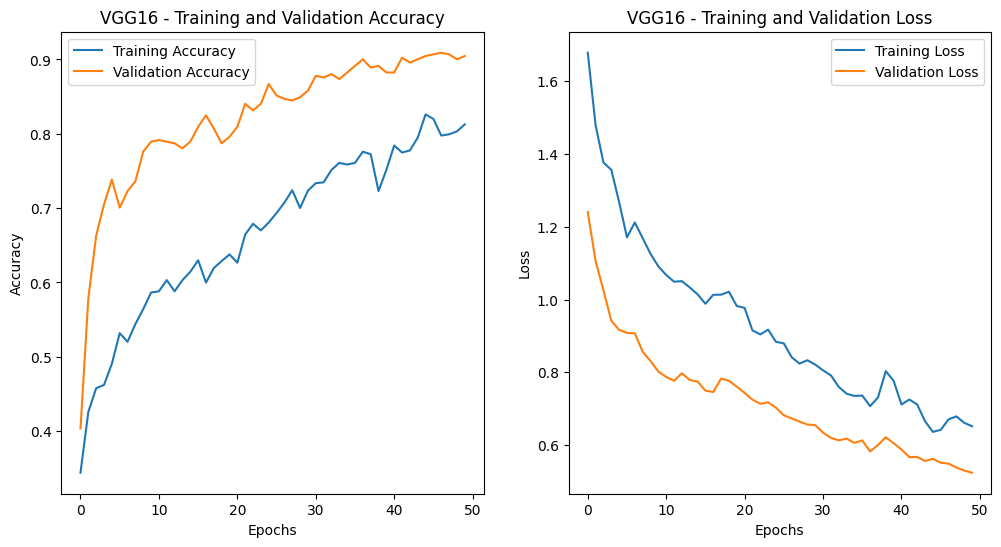

In [271]:
def plot_history(history):
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{"VGG16"} - Training and Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{"VGG16"} - Training and Validation Loss')
    plt.legend()

    plt.show()


plot_history(track_history)


In [217]:
# Function to evaluate one model and return metrics
import numpy as np
from sklearn.preprocessing import label_binarize
def evaluate_model(model, test_ds, num_classes):
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Extract test images and labels
    test_images = np.concatenate([x.numpy() for x, _ in test_ds])
    test_labels = np.concatenate([y.numpy() for _, y in test_ds])

    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # Predict class probabilities
    predictions = model.predict(test_images)  # Use only one set of test images
    predicted_classes = np.argmax(predictions, axis=1)       # Get the predicted class indices
    true_classes = np.argmax(test_labels, axis=1)            # Convert one-hot labels to class indices

    return test_loss, test_accuracy, true_classes, predicted_classes, predictions

# Function to plot confusion matrix
def plot_confusion_matrix(true_classes, predicted_classes, class_names):
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(predictions, true_classes, num_classes):
    # Binarize the test labels (for multi-class ROC)
    y_test_bin = label_binarize(true_classes, classes=np.arange(num_classes))

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9112 - loss: 0.5308
Test Loss: 0.5371676087379456
Test Accuracy: 0.9147424697875977
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


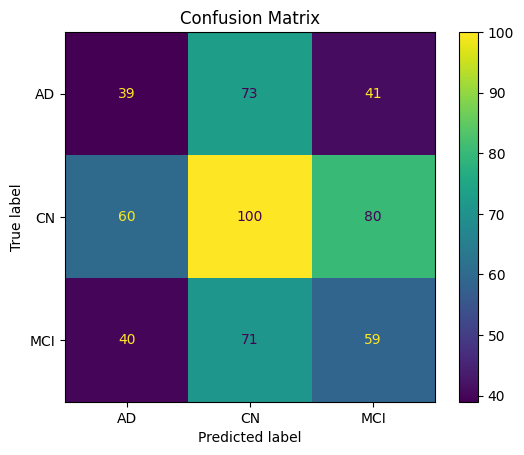

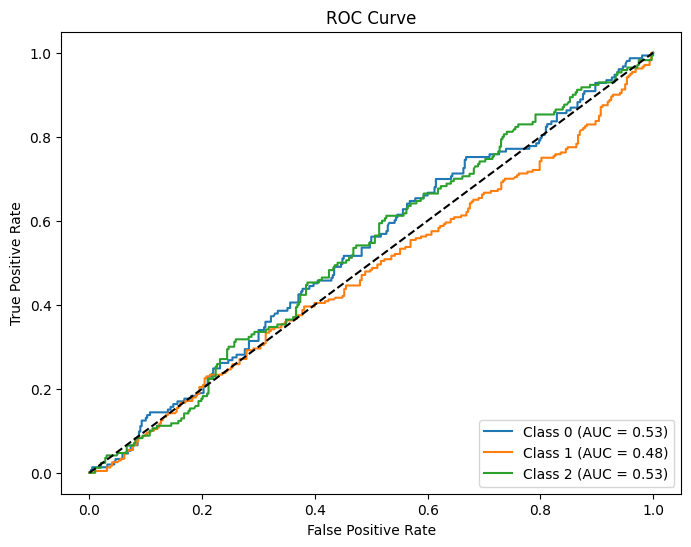

Classification Report for VGG16:
              precision    recall  f1-score   support

          AD       0.28      0.25      0.27       153
          CN       0.41      0.42      0.41       240
         MCI       0.33      0.35      0.34       170

    accuracy                           0.35       563
   macro avg       0.34      0.34      0.34       563
weighted avg       0.35      0.35      0.35       563



In [272]:
# Define number of classes and class names (like ['AD', 'CN', 'MCI'])
num_classes = 3
class_names = ['AD', 'CN', 'MCI']

# Evaluate and plot for each model

test_loss, test_accuracy, true_classes, predicted_classes, predictions = evaluate_model(model, test_ds, num_classes)
plot_confusion_matrix(true_classes, predicted_classes, class_names)
plot_roc_curve(predictions, true_classes, num_classes)

    # Generate and print classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(f"Classification Report for {'VGG16'}:\n{report}")


# track_history.history['test_accuracy_cnn1'] = test_accuracy


# # Plotting Training, Validation, and Test accuracies
# plt.figure(figsize=(8, 6))
# plt.plot(track_history.history['accuracy'], label='Training Accuracy VGG16')
# plt.plot(track_history.history['val_accuracy'], label='Validation Accuracy VGG16')
# plt.axhline(y=track_history.history['test_accuracy_VGG16'], color='b', linestyle='--', label='Test Accuracy VGG16')



# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training, Validation, and Test Accuracy')
# plt.legend()
# plt.show()